
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

## Interactive Gradient Descent

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


### PGE 383 Exercise: Interactive Gradient Descent

Here's a simple demonstration of gradient descent. 

* I also have a lecture that describes the basics of optimization for machine learning model training, [Optimization Lecture](https://www.youtube.com/watch?v=4nYz5j0sAQs&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=23&t=578s) that may be helpful.

In this demonstration you will be able to take a customimizable loss function.

* you can vary the magnitude and spatial correlation of the noise

* **magnitude of noise** is controlled by the standard deviation of a Gaussian random residual 

* **spatialcorrelation of noise** is controlled by the size of a Gaussian kernal applied to convolve the random noise to impose spatial structure 

Then you can set the:

* **initial parameter combination** ($\phi_1, \phi_2$)

* **initial learning rate** \[0.1,5\]

* **momentum** \[0.0,1.0\]

* **exponential decay coefficient**

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
%matplotlib inline
%matplotlib notebook
import os
import sys                                              # supress output to screen for interactive variogram modeling                                             
import math                                             # square root operator
import numpy as np                                      # arrays and matrix math
import matplotlib.pyplot as plt                         # plotting
import scipy                                            # kernel for convolution
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
import scipy.signal as signal
from scipy.interpolate import RegularGridInterpolator
from matplotlib import animation

In [2]:
os.chdir(r'C:\Users\pm27995\OneDrive - The University of Texas at Austin\Courses\Workflows') # set current directory for gif file

#### Set the Parameters for The Demonstration

Here we set the grid size and extent, and color map applied in this demonstration.

In [3]:
nx = 100; ny = 100                                      # size of the loss function grid
cmap = plt.cm.inferno                                   # set the colormap
xmin = 0.0; xmax = 100.0; ymin = 0.0; ymax = 100.0      # set the extents
X, Y = np.mgrid[ymin:ymax:complex(ny), 0:100:complex(nx)] # make location mesh for interpolation method
XY = np.vstack((Y.flatten(), X.flatten())).T            
XY_list = list(map(tuple, XY))                           
x = np.zeros(100); y = np.zeros(100)                    # initialize the descent path
truth = np.zeros([100,100])                             # initialize the 2D loss function map
np.random.seed(73073)                                   # set random number seed for repeatable results

#### Make the Exhaustive Loss Function

Let's ensure a global minimum in the middle of the solution space and add some structured noise to increase the difficulty

* local minimums for gradient descent to get stuck

<IPython.core.display.Javascript object>


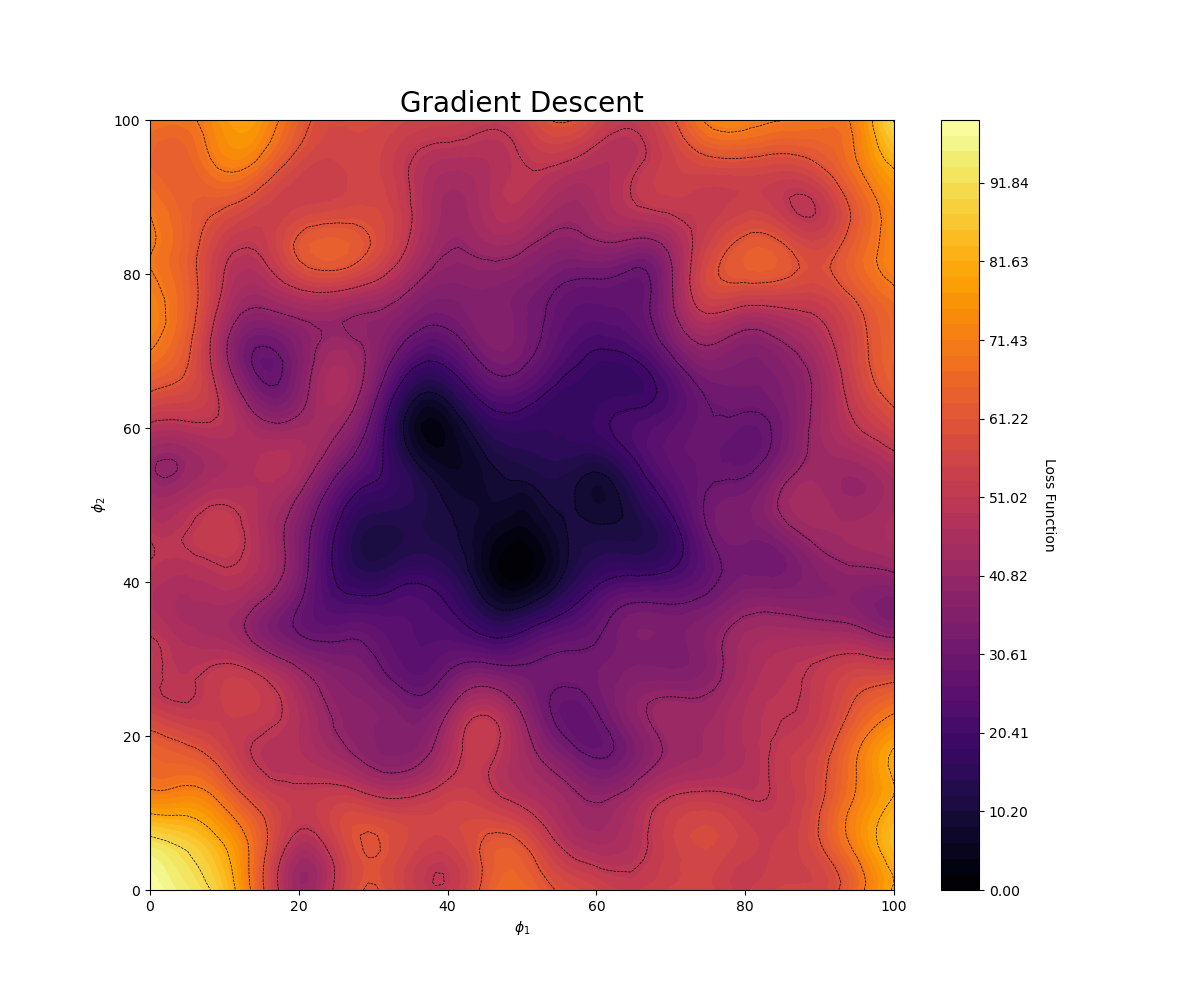

Text(0.5, 1.0, 'Gradient Descent')

In [4]:
# Make the truth loss function
nsmooth = 20                                            # controls the spatial continuity in the noise, in cells
noise_std = 80.0

for iy in range(100):
    for ix in range(100):
        truth[iy,ix] = math.sqrt((iy-50)*(iy-50) + (ix-50)*(ix-50))

noise = np.random.normal(loc=0.0, scale=1.0, size=(100,100))
w = np.ones((nsmooth,nsmooth))/(nsmooth*nsmooth)

gkern1d = signal.gaussian(nsmooth, std=nsmooth*0.2).reshape(nsmooth, 1); gkern2d = np.outer(gkern1d, gkern1d) # Teddy Hartanto, 2017, stack overflow 
gkern2d = gkern2d/np.sum(gkern2d.flatten())

noise = signal.convolve2d(noise,gkern2d,mode = 'same',boundary='symm')   

truth = truth + noise*noise_std

truth = (truth - np.min(truth))/(np.max(truth) - np.min(truth))*100.0

# initialize the fast interpolator to evaluate the loss function at any location
interp = RegularGridInterpolator((np.linspace(ymin,ymax,ny),np.linspace(xmin,xmax,nx)),truth, method = 'linear')
x = np.zeros(100); y = np.zeros(100)                          # descent path arrays

fig = plt.figure(figsize = (12,10)); ax = plt.gca()
plt.xlim([0,100]); plt.ylim([0,100])
c1 = ax.contourf(X, Y, truth, cmap = plt.cm.inferno,vmin=0,vmax=100,levels=np.linspace(0, 100, 50))
ax.contour(X, Y, truth, levels=10, linewidths=0.5, colors='black',linestyles='dashed') 
cbar = plt.colorbar(c1);
cbar.set_label('Loss Function',rotation = 270,labelpad = 20)
plt.rc('xtick', labelsize=10); plt.rc('ytick', labelsize=10) 
plt.rc('axes', titlesize=20); plt.rc('axes', labelsize=15)
plt.xlabel(r'$\phi_1$'); plt.ylabel(r'$\phi_2$'); plt.title('Gradient Descent')

#### Set Parameters for this Model Run and Run the Animation

You can change the following parameters and then watch the animation of the gradient descent path.

* **r** - learning rate (distance units of the \[0,100\] parmaeter space 
* **momentum - momentum weight (weight on the previous step), from \[0.0 - no mommentum, 1.0 - next step is previous step\]
* **make_video** - False, run and visualize, True, only make the specified mpeg video file
* **x\[0\]**, **y\[0\]** - initial location for descent path 
* **delta** - offset applied for numerical differentiation to calculate the local gradient by sampling

In [8]:
r0 = 7.0                                     # initial learning rate
momentum = 0.8                               # momentum                         
delta = 0.001                                # delta for numerical differentiation of the loss function
k = 0.04                                     # exponential decay parameter
x = np.zeros(100); y = np.zeros(100)         # initialize the descent path array
x[0] = 5.0; y[0] = 50.0                      # initial location in the parameter space
make_video = True                            # make a video (True or False)

#### Gradient Descent Path Animation \#1

The following animation shows the gradient descent path given the above loss function and gradient descent parameters.

<IPython.core.display.Javascript object>


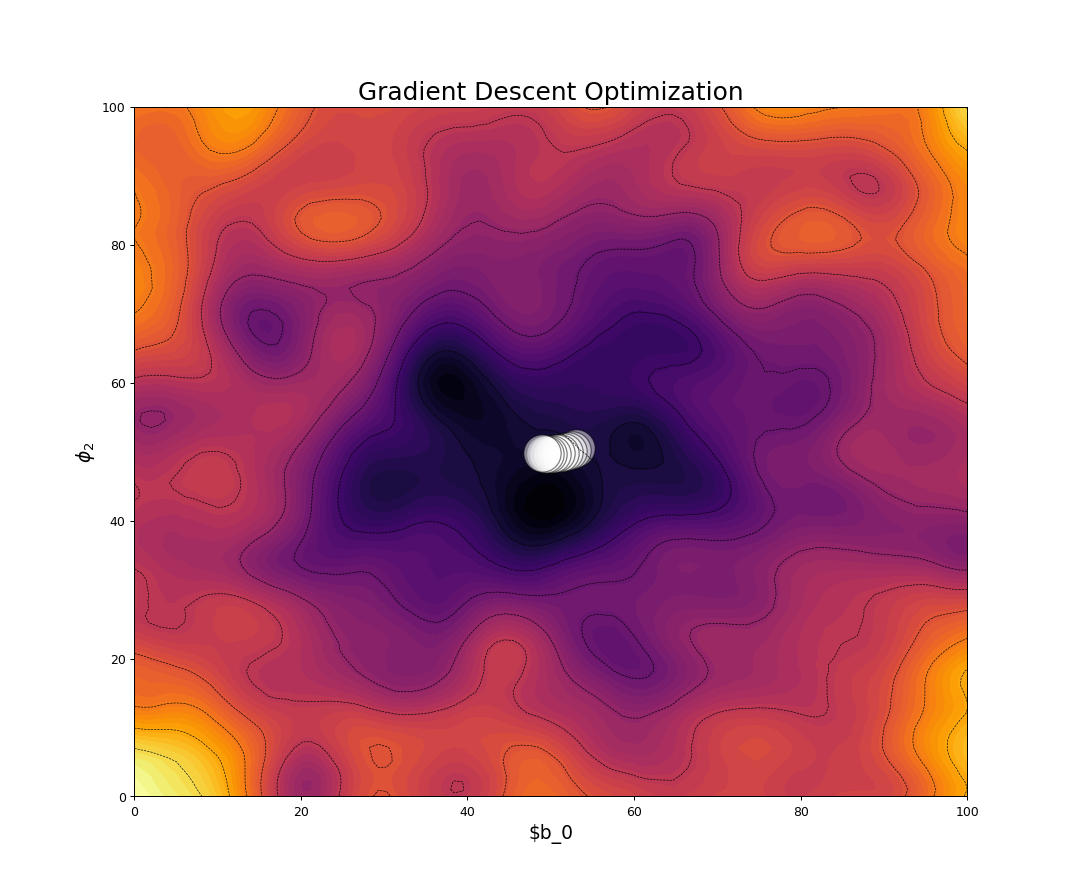

saving video


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [9]:
plt.close()
# set up the plot
fig = plt.figure(figsize = (12,10))
ax = plt.gca()
ax.set_xlim([xmin,xmax]); ax.set_ylim([ymin,ymax])
ax.set_xlabel(r'$\phi_1$'); ax.set_ylabel(r'$\phi_2$'); ax.set_title('Gradient Descent Optimization')
plt.rc('xtick', labelsize=10); plt.rc('ytick', labelsize=10) 
plt.rc('axes', titlesize=20); plt.rc('axes', labelsize=15) 
point, = ax.plot([],[], marker="o",c='white', 
            markeredgecolor = "black", ms=30, alpha = 0.5)
cbar = plt.colorbar(c1);
cbar.set_label('Loss Function',rotation = 270,labelpad = 20)
global line

x = np.clip(x,xmin+delta,xmax-delta); y = np.clip(y,ymin+delta,ymax-delta) # ensure start is not too close to edge
for i in range(1,100):    
    gradient_x = (interp((y[i-1], x[i-1]+delta)).item()-interp((y[i-1], x[i-1]-delta)).item())/(2*delta)
    gradient_y = (interp((y[i-1]+delta, x[i-1])).item()-interp((y[i-1]-delta, x[i-1])).item())/(2*delta)
    
    r = r0 * math.exp(-k*i)    
    
    if i > 1: # include mommentum
        x_step = momentum*prev_x + (1.0-momentum)*(-1*r*gradient_x) # integrat momentum
        y_step = momentum*prev_y + (1.0-momentum)*(-1*r*gradient_y) # integrat momentum
    else: 
        x_step = -1*r*gradient_x 
        y_step = -1*r*gradient_y 
      
    x[i] = x[i-1] + x_step                   # step forward
    y[i] = y[i-1] + y_step 
    
    x[i] = np.clip(x[i],xmin+delta,xmax-delta); y[i] = np.clip(y[i],ymin+delta,ymax-delta) # ensure point is not too close to edge

    prev_x = (x[i] - x[i-1])                 # store current step for momentum on next step
    prev_y = (y[i] - y[i-1])
               
def init():                                  # animation initialization function
    ax = plt.gca()
    c1 = ax.contourf(X, Y, truth, cmap = plt.cm.inferno,vmin=0,vmax=100,levels=np.linspace(0, 100, 50))
    ax.contour(X, Y, truth, levels=10, linewidths=0.5, colors='black',linestyles='dashed')
    plt.xlabel('$b_0')
    
def update(frame):                          # animation steps over frames
    N = 10
    ax = plt.gca()
    N = min(N,frame)
    top = min(frame,90)
    point.set_data(x[frame-N:top],y[frame-N:top])

ani = FuncAnimation(fig, update, frames = np.arange(1, len(x)-20), init_func = init, # make the animation
    interval=100, blit=True, repeat = False)

if make_video:                               # set up formatting for the movie files
    writer = animation.FFMpegWriter(fps=15, metadata=dict(artist='Michael Pyrcz'), bitrate=100000)
    print('saving video')
    ani.save(r'gradient_descent.mp4', writer=writer)
    

An example that works pretty good:
    
```python
r0 = 5.0                                     # initial learning rate
momentum = 0.9                               # momentum                         
delta = 0.001                                # delta for numerical differentiation of the loss function
```

#### Gradient Descent Path Animation \#2

Here's another animation that shows the gradient descent path given the above loss function and gradient descent parameters.

* this time we provide the path and do not repeat the animation

* I thought this would be a useful alternative to visualize this information

<IPython.core.display.Javascript object>


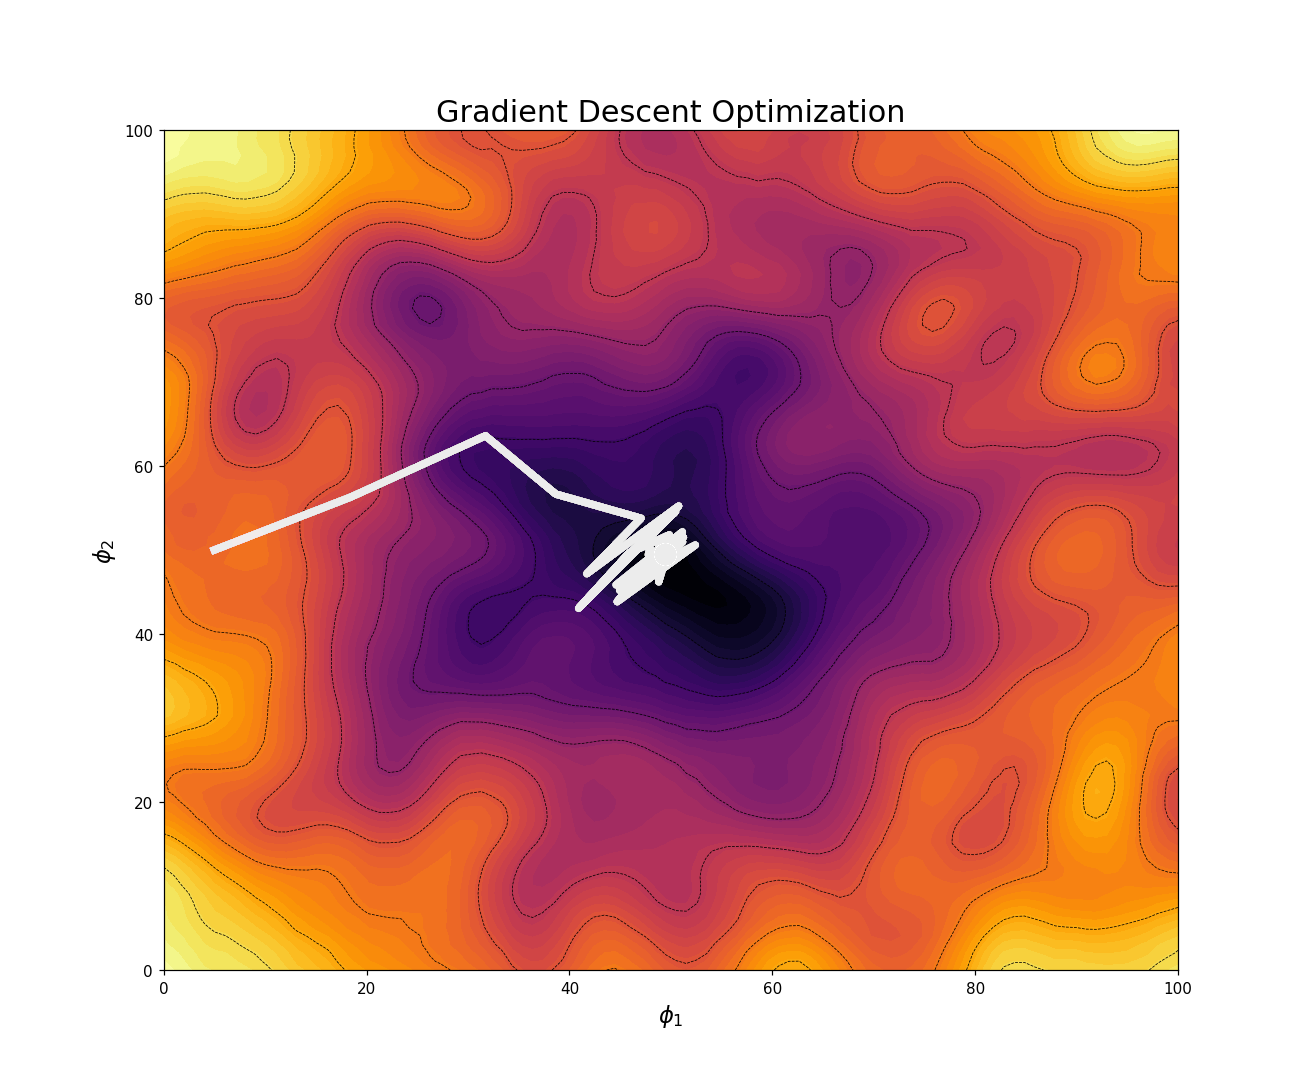

In [7]:
# set up the plot
fig = plt.figure(figsize = (12,10))
ax = plt.gca()
ax.set_xlim([xmin,xmax]); ax.set_ylim([ymin,ymax])
ax.set_xlabel(r'$\phi_1$'); ax.set_ylabel(r'$\phi_2$'); ax.set_title('Gradient Descent Optimization')
plt.rc('xtick', labelsize=10); plt.rc('ytick', labelsize=10) 
plt.rc('axes', titlesize=20); plt.rc('axes', labelsize=15) 
point, = ax.plot([],[], marker="o",c=plt.cm.inferno((interp((x[0],y[0])).item())/100), 
            markeredgecolor = "white", ms=15, alpha = 1.0)
cbar = plt.colorbar(c1);
cbar.set_label('Loss Function',rotation = 270,labelpad = 20)
global line

x = np.clip(x,xmin+delta,xmax-delta); y = np.clip(y,ymin+delta,ymax-delta) # ensure start is not too close to edge

for i in range(1,100):    
    gradient_x = (interp((y[i-1], x[i-1]+delta)).item()-interp((y[i-1], x[i-1]-delta)).item())/(2*delta)
    gradient_y = (interp((y[i-1]+delta, x[i-1])).item()-interp((y[i-1]-delta, x[i-1])).item())/(2*delta)
    
    r = r0 * math.exp(-k*i)    
    
    if i > 1: # include mommentum
        x_step = momentum*prev_x + (1.0-momentum)*(-1*r*gradient_x) # integrat momentum
        y_step = momentum*prev_y + (1.0-momentum)*(-1*r*gradient_y) # integrat momentum
    else: 
        x_step = -1*r*gradient_x 
        y_step = -1*r*gradient_y 
      
    x[i] = x[i-1] + x_step                               # step forward
    y[i] = y[i-1] + y_step 
    
    x[i] = np.clip(x[i],xmin+delta,xmax-delta); y[i] = np.clip(y[i],ymin+delta,ymax-delta) # ensure point is not too close to edge

    prev_x = (x[i] - x[i-1])                              # store current step for momentum on next step
    prev_y = (y[i] - y[i-1])
               
def init():                                             # animation initialization function
    ax = plt.gca()
    c1 = ax.contourf(X, Y, truth, cmap = plt.cm.inferno,vmin=0,vmax=100,levels=np.linspace(0, 100, 50))
    ax.contour(X, Y, truth, levels=10, linewidths=0.5, colors='black',linestyles='dashed') 
    
def update(frame):
    N = 5
    ax = plt.gca()     
    point.set_data(x[frame],y[frame])
    point.set_color(plt.cm.inferno((interp((y[frame],x[frame])).item())/100))
    line, = plt.plot(x[:frame],y[:frame],c='white',alpha=0.05,linewidth=5)

ani = FuncAnimation(fig, update, frames = np.arange(1, len(x)), init_func = init, # make the animation
    interval=100, blit=True, repeat = False)

if make_video:                                               # set up formatting for the movie files
    writer = animation.FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('gradient_descent.mp4', writer=writer)
    

#### Comments

This was a basic demonstration of gradient descent optimization, commonly applied to train machine learning models. 

* I have many other demonstrations and even basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 

* Also, check out my YouTube channel. I put all my university lectures online [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig). 
  
#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  